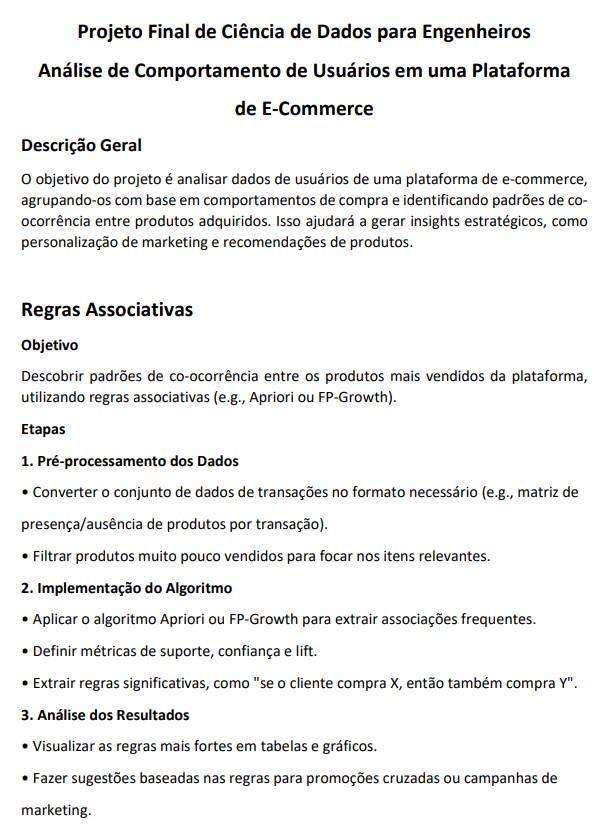

# --- Etapa 1: Pré-processamento dos Dados ---

In [25]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

df = pd.read_csv('walmart.csv')

print("Primeiras 5 linhas do dataset:")
print(df.head())

print("\nInformações do dataset:")
df.info()

Primeiras 5 linhas do dataset:
   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category  Purchase  
0                          2               0                 3      8370  
1                          2               0                 1     15200  
2                          2               0                12      1422  
3                          2               0                12      1057  
4                         4+               0                 8      7969  

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns)

Agrupar os produtos por 'Purchase' (transação), Criamos uma lista de listas, onde cada sublista contém os produtos de uma transação, removemos valores nulos na coluna 'Product_ID' para evitar erros.

In [26]:
transacoes = df.dropna(subset=['Product_ID']).groupby('Purchase')['Product_ID'].apply(list).tolist()
print("\nPrimeiras 5 transações processadas:")
print(transacoes[:5])




Primeiras 5 transações processadas:
[['P00370293', 'P00370293', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370293', 'P00370293', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370853', 'P00370853', 'P00370853', 'P00370293', 'P00370293', 'P00370853', 'P00370293', 'P00370853', 'P00370293', 'P00370853', 'P00370293', 'P00370853', 'P00370853', 'P00370853', 'P00370853', 'P00370293', 'P00370853', 'P00370293', 'P00370853', 'P00370853', 'P00370853', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370853', 'P00370293', 'P00370853', 'P00370853', 'P00370853', 'P00370293', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370853', 'P00370293', 'P00370853', 'P00370293', 'P00370293', 'P00370293', 'P00370853', 'P00370853', 'P00370853',


Filtrar produtos muito pouco vendidos para focar nos itens relevantes. Para fazer isso de forma eficaz, precisamos primeiro criar uma representação de presença/ausência.


Usar TransactionEncoder para converter a lista de transações em um formato one-hot encoded. Isso cria uma matriz onde cada linha é uma transação e cada coluna é um produto, com True se o produto está na transação e False caso contrário.

Calcular a frequência de cada produto. Somando as colunas (True = 1, False = 0) para obter a contagem de transações em que cada produto aparece

In [27]:
te = TransactionEncoder()
te_ary = te.fit(transacoes).transform(transacoes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("\nPrimeiras 5 linhas do DataFrame one-hot encoded:")
print(df_encoded.head())


product_counts = df_encoded.sum().sort_values(ascending=False)

print("\nContagem dos 10 produtos mais vendidos:")
print(product_counts.head(10))


Primeiras 5 linhas do DataFrame one-hot encoded:
   P00000142  P00000242  P00000342  P00000442  P00000542  P00000642  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

   P00000742  P00000842  P00000942  P00001042  ...  P0098942  P0099042  \
0      False      False      False      False  ...     False     False   
1      False      False      False      False  ...     False     False   
2      False      False      False      False  ...     False     False   
3      False      False      False      False  ...     False     False   
4      False      False      False      False  ...     False     False   

   P0099142  P0099242  P0099342  P0099442  P0099642  P0099742  P0099842  \
0  

Definir um limite mínimo para a frequência dos produtos. Produtos que aparecem em menos de 'min_product_frequency' transações serão removidos. Este é um hiperparâmetro que pode ser ajustado com base na densidade dos dados e no objetivo da análise. Por exemplo, vamos considerar produtos que aparecem em pelo menos 1% das transações.

In [28]:
min_product_frequency = 0.01 * len(df_encoded)
print(f"\nNúmero mínimo de ocorrências para um produto ser considerado relevante (1% das transações): {min_product_frequency:.0f}")



Número mínimo de ocorrências para um produto ser considerado relevante (1% das transações): 181


Filtrar o DataFrame one-hot encoded para manter apenas os produtos relevantes. Selecionar apenas as colunas (produtos) cuja contagem é maior ou igual ao limite definido

In [29]:
relevant_products = product_counts[product_counts >= min_product_frequency].index
df_filtered = df_encoded[relevant_products]

print(f"\nDimensões do DataFrame após filtragem de produtos pouco vendidos: {df_filtered.shape}")
print("Primeiras 5 linhas do DataFrame filtrado:")
print(df_filtered.head())


Dimensões do DataFrame após filtragem de produtos pouco vendidos: (18105, 890)
Primeiras 5 linhas do DataFrame filtrado:
   P00112142  P00110742  P00046742  P00145042  P00057642  P00025442  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

   P00059442  P00010742  P00184942  P00242742  ...  P00329342  P00285442  \
0      False      False      False      False  ...      False      False   
1      False      False      False      False  ...      False      False   
2      False      False      False      False  ...      False      False   
3      False      False      False      False  ...      False      False   
4      False      False      False      False  ...      False      Fals

# --- Etapa 2: Implementação do Algoritmo ---

Aplicar o algoritmo Apriori para extrair conjuntos de itens frequentes, min_support é a porcentagem mínima de transações que um conjunto de itens deve ter para ser considerado frequente. Ajuste este valor conforme a necessidade. Um valor menor pode gerar mais conjuntos, um valor maior menos. Usaremos um valor inicial de 0.02 (2% das transações) ja que nos primeiros testes 0.01 (1%) deu extouro de memória.

In [30]:
frequent_itemsets = apriori(df_filtered, min_support=0.02, use_colnames=True)

print("\nTop 10 conjuntos de itens frequentes (Apriori):")
print(frequent_itemsets.nlargest(10, 'support'))


Top 10 conjuntos de itens frequentes (Apriori):
    support     itemsets
0  0.063187  (P00112142)
1  0.061696  (P00110742)
2  0.061475  (P00046742)
3  0.060922  (P00145042)
4  0.059983  (P00057642)
5  0.058768  (P00025442)
6  0.057167  (P00059442)
7  0.056725  (P00010742)
8  0.056614  (P00184942)
9  0.055510  (P00242742)


Um valor de 0.5 significa que a regra 'Se X, então Y' é verdadeira em pelo menos 50% das vezes que X ocorre.



In [31]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)


 Ordenar as regras por 'lift' em ordem decrescente
 - Lift mede a melhora na probabilidade de compra de Y quando X é comprado, em relação à compra de Y independentemente.
 - Lift > 1 indica uma associação positiva.
 - Lift < 1 indica uma associação negativa.
 - Lift = 1 indica independência.

In [32]:
rules = rules.sort_values(by='lift', ascending=False)

print("\nTop 10 regras de associação (ordenadas por Lift):")
print(rules.head(10))


Top 10 regras de associação (ordenadas por Lift):
     antecedents  consequents  antecedent support  consequent support  \
165  (P00085242)  (P00031042)            0.031980            0.035460   
166  (P00031042)  (P00085242)            0.035460            0.031980   
154  (P00051442)  (P00031042)            0.037945            0.035460   
153  (P00031042)  (P00051442)            0.035460            0.037945   
164  (P00031042)  (P00110542)            0.035460            0.034245   
163  (P00110542)  (P00031042)            0.034245            0.035460   
156  (P00051442)  (P00110542)            0.037945            0.034245   
155  (P00110542)  (P00051442)            0.034245            0.037945   
160  (P00051442)  (P00085242)            0.037945            0.031980   
159  (P00085242)  (P00051442)            0.031980            0.037945   

      support  confidence       lift  representativity  leverage  conviction  \
165  0.020989    0.656304  18.508385               1.0  0.019855 

# --- Etapa 3: Análise dos Resultados ---

Filtrar regras com alto lift e confiança para análise mais detalhada. Podemos filtrar regras com confiança acima de um certo limiar e lift também acima de 1.

In [33]:

significant_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.5)]
print("\nRegras de associação mais significativas (Confidence > 0.6 e Lift > 1.5):")
print(significant_rules)


Regras de associação mais significativas (Confidence > 0.6 e Lift > 1.5):
     antecedents  consequents  antecedent support  consequent support  \
165  (P00085242)  (P00031042)            0.031980            0.035460   
154  (P00051442)  (P00031042)            0.037945            0.035460   
153  (P00031042)  (P00051442)            0.035460            0.037945   
164  (P00031042)  (P00110542)            0.035460            0.034245   
163  (P00110542)  (P00031042)            0.034245            0.035460   
..           ...          ...                 ...                 ...   
49   (P00174442)  (P00265242)            0.029881            0.047611   
32   (P00251242)  (P00265242)            0.039602            0.047611   
36   (P00178942)  (P00265242)            0.032919            0.047611   
84   (P00086442)  (P00058042)            0.037780            0.043082   
41   (P00250242)  (P00265242)            0.031980            0.047611   

      support  confidence       lift  representa

Gráfico de Dispersão de Suporte vs. Confiança vs. Lift

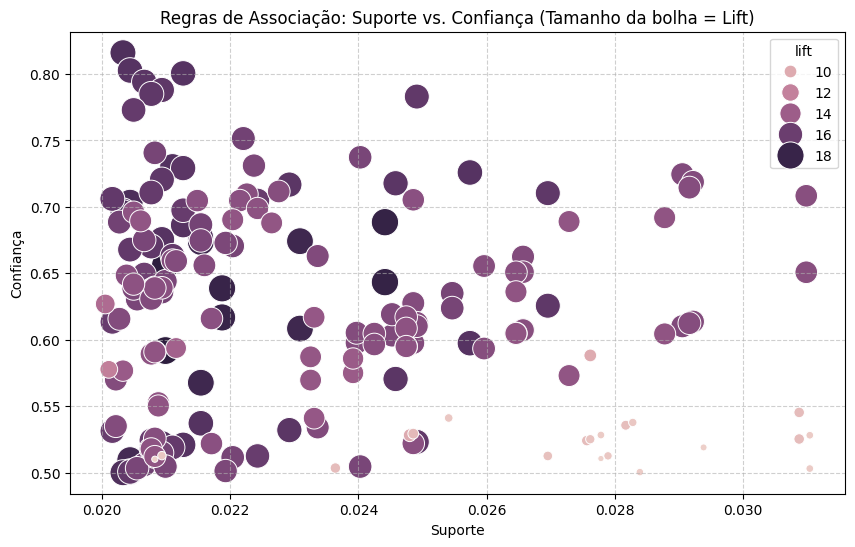

In [34]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x="support", y="confidence", size="lift", data=rules, hue="lift", sizes=(20, 400), legend="brief")
plt.title('Regras de Associação: Suporte vs. Confiança (Tamanho da bolha = Lift)')
plt.xlabel('Suporte')
plt.ylabel('Confiança')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Gráfico de Barras dos Top N Antecedentes/Consequentes

C:\Users\marco\AppData\Local\Temp\ipykernel_36436\360573998.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequência', y='Produto', data=df_antecedents.head(10), palette='viridis')


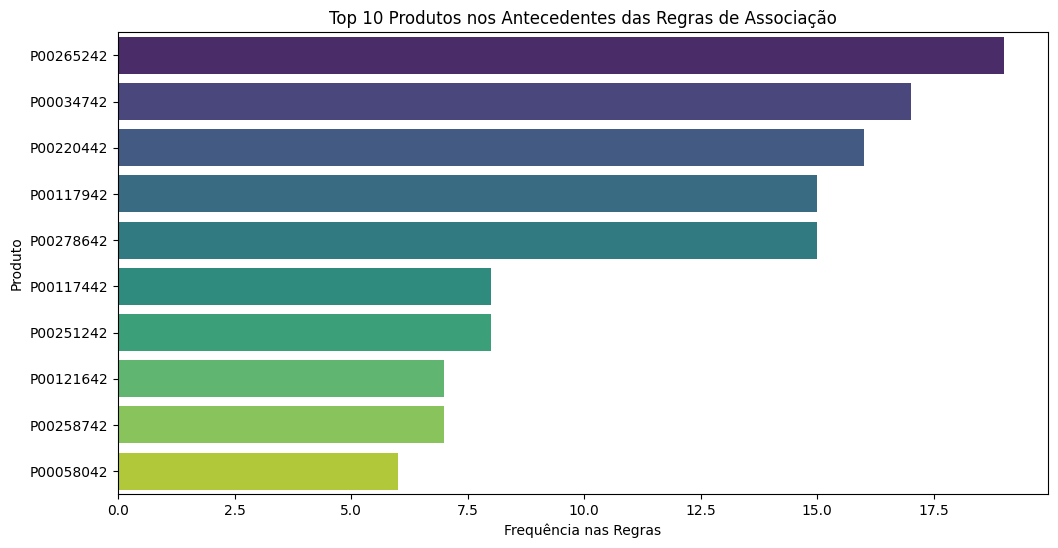

C:\Users\marco\AppData\Local\Temp\ipykernel_36436\360573998.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequência', y='Produto', data=df_consequents.head(10), palette='magma')


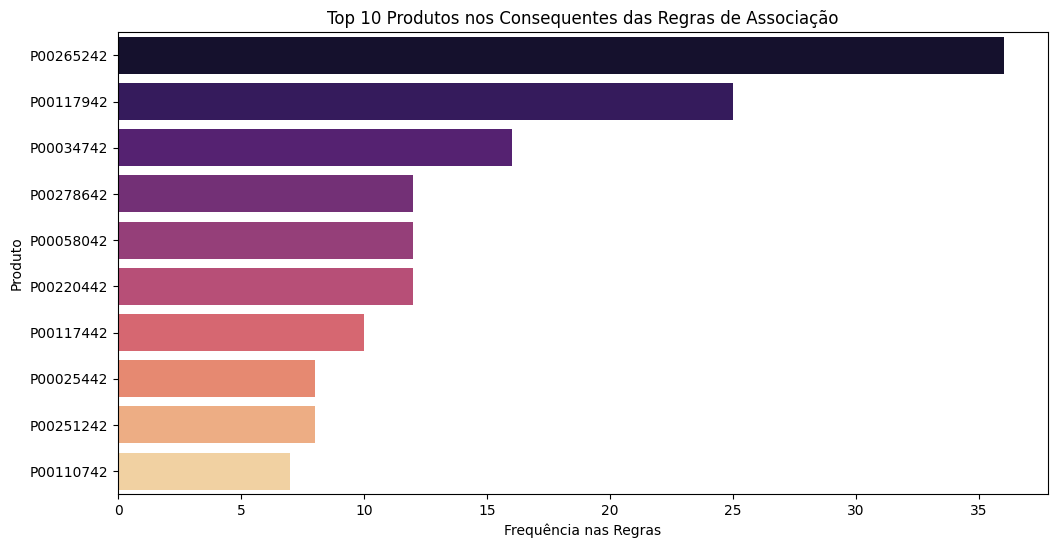

In [35]:
all_antecedents = [item for sublist in rules['antecedents'] for item in sublist]
all_consequents = [item for sublist in rules['consequents'] for item in sublist]

antecedent_counts = Counter(all_antecedents)
df_antecedents = pd.DataFrame(antecedent_counts.items(), columns=['Produto', 'Frequência']).sort_values(by='Frequência', ascending=False)

consequent_counts = Counter(all_consequents)
df_consequents = pd.DataFrame(consequent_counts.items(), columns=['Produto', 'Frequência']).sort_values(by='Frequência', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequência', y='Produto', data=df_antecedents.head(10), palette='viridis')
plt.title('Top 10 Produtos nos Antecedentes das Regras de Associação')
plt.xlabel('Frequência nas Regras')
plt.ylabel('Produto')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequência', y='Produto', data=df_consequents.head(10), palette='magma')
plt.title('Top 10 Produtos nos Consequentes das Regras de Associação')
plt.xlabel('Frequência nas Regras')
plt.ylabel('Produto')
plt.show()

Análise realizada baseada nas regras

In [36]:
print("\n--- Análise e Sugestões Baseadas nas Regras ---")


if not significant_rules.empty:
    for index, row in significant_rules.iterrows():
        antecedents = list(row['antecedents']) # Produtos que são comprados (parte 'se')
        consequents = list(row['consequents']) # Produtos que tendem a ser comprados em seguida (parte 'então')
        confidence = row['confidence']
        lift = row['lift']

        print(f"\nRegra: Se o cliente compra {antecedents}, então ele também tende a comprar {consequents}.")
        print(f"  - Confiança: {confidence:.2f} (Isso significa que {confidence*100:.0f}% das transações que contêm {antecedents} também contêm {consequents}.)")
        print(f"  - Lift: {lift:.2f} (Um Lift maior que 1 ({lift:.2f}) indica que a associação é mais forte do que a ocorrência esperada por acaso. Neste caso, é {lift:.2f} vezes mais provável que {consequents} seja comprado quando {antecedents} é comprado, comparado à compra de {consequents} independentemente.)")

        print("  Sugestões de Marketing:")
        print(f"    - **Recomendação de Produtos:** Se um cliente adicionar {antecedents} ao carrinho, recomende ativamente {consequents}.")
        print(f"    - **Promoção Cruzada:** Crie combos promocionais ou ofertas do tipo 'compre {antecedents} e ganhe desconto em {consequents}'.")
        print(f"    - **Layout da Loja/Site:** Posicione {consequents} próximos a {antecedents} em prateleiras físicas ou páginas de produtos online para incentivar a compra conjunta.")
        print(f"    - **Campanhas de Email Marketing:** Segmente clientes que compraram {antecedents} e envie e-mails sugerindo {consequents}.")
else:
    print("Nenhuma regra significativa encontrada com os filtros atuais. Tente ajustar os parâmetros (min_support, min_threshold para confidence/lift).")

print("\n--- Fim da Análise ---")


--- Análise e Sugestões Baseadas nas Regras ---

Regra: Se o cliente compra ['P00085242'], então ele também tende a comprar ['P00031042'].
  - Confiança: 0.66 (Isso significa que 66% das transações que contêm ['P00085242'] também contêm ['P00031042'].)
  - Lift: 18.51 (Um Lift maior que 1 (18.51) indica que a associação é mais forte do que a ocorrência esperada por acaso. Neste caso, é 18.51 vezes mais provável que ['P00031042'] seja comprado quando ['P00085242'] é comprado, comparado à compra de ['P00031042'] independentemente.)
  Sugestões de Marketing:
    - **Recomendação de Produtos:** Se um cliente adicionar ['P00085242'] ao carrinho, recomende ativamente ['P00031042'].
    - **Promoção Cruzada:** Crie combos promocionais ou ofertas do tipo 'compre ['P00085242'] e ganhe desconto em ['P00031042']'.
    - **Layout da Loja/Site:** Posicione ['P00031042'] próximos a ['P00085242'] em prateleiras físicas ou páginas de produtos online para incentivar a compra conjunta.
    - **Campanha